## Stack breakdown

This example notebook shows how to supply parameter to TEA classes, how to plot mass- and volume loadings and how to estimate energy densities with different parameters.

TEA classes can be created with a PyBaMM parameter-set and an additional input parameter-set, which can contain densities, as below.

In [ ]:
import pybamm
from pybamm_tea import tea
import numpy as np
import matplotlib.pyplot as plt

/Users/robertwtimms/Documents/pybamm-tea/pybamm_tea/tea.py:864: UserWarning: Warning: Negative electrode inactive material volume fraction is 0, Negative electrode inactive material density is set to 0
  warnings.warn(
/Users/robertwtimms/Documents/pybamm-tea/pybamm_tea/tea.py:864: UserWarning: Warning: Positive electrode inactive material volume fraction is 0, Positive electrode inactive material density is set to 0
  warnings.warn(


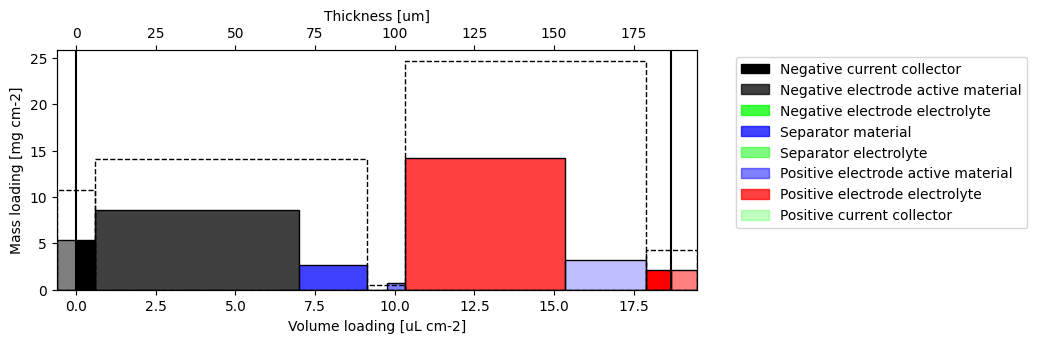

,Volume loading [uL.cm-2],Mass loading [mg.cm-2],Density [mg.uL-1]
Negative electrode electrolyte,2.1300,2.717880,1.276000
Negative electrode active material,6.3900,8.549820,1.338000
Negative electrode inactive material,0.0000,0.000000,0.000000
Negative electrode dry,8.5200,11.399760,1.338000
Negative electrode,8.5200,14.117640,1.657000
Positive electrode electrolyte,2.5326,3.231598,1.276000
Positive electrode active material,5.0274,14.250366,2.834540
Positive electrode inactive material,0.0000,0.000000,0.000000
Positive electrode dry,7.5600,21.429122,2.834540
Positive electrode,7.5600,24.660720,3.262000


In [1]:
# input parameter-set
input = {
    "Electrolyte density [kg.m-3]": 1276, # LiPF6 in EC:EMC 3:7 + 2% VC
}

# base parameter-sets
base = pybamm.ParameterValues("Chen2020")

# create a TEA class
tea_class = tea.TEA(base, input)

# plot the mass and volume loadings
tea_class.plot_stack_breakdown()

# get the mass and volume loadings as a dataframe
tea_class.stack_breakdown_dataframe


### Did you spot the negative separator material density?

The inactive/separator material density is calculated as the remainder from the (parameter-set-) electrode/separator density and the (input-) active material & electrolyte density with respect to the volume fractions.
\begin{equation}
\rho_{\text {separator material}}=\frac{\rho_{\text {separator }}-\varepsilon_{}\rho_{\text {electrolyte }}}{v_{\text {separator material}}}
\end{equation}

\begin{equation}
\rho_{\text {inactive }}=\frac{\rho_{\text {electrode }}-v_{\text {active }} \rho_{\text {active }}-\varepsilon_{}\rho_{\text {electrolyte }}}{v_{\text {inactive }}}
\end{equation}\tag{2}

In this specific example case, the value for the (wet) separator density is the value of the dry separator density, which leads to the negative value, similarly also inactive material densities can become negative. Luckily, densities can easily be updated and calculated. Another special case of this parameter-set is that there are no inactive materials considered explicitly, so that no active material densities need to be provided, as they can be calculated as the dry electrode densities. If inactive materials are added also densities for the active materials need to be supplied.

Let's update the separator density and add inactive materials.

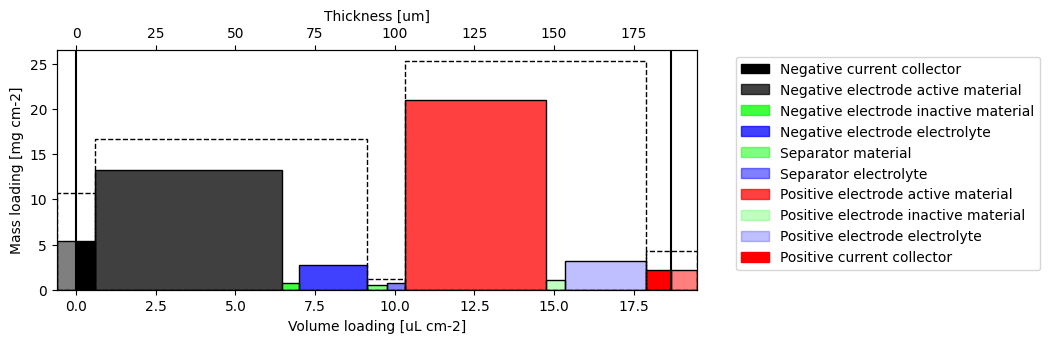

,Volume loading [uL.cm-2],Mass loading [mg.cm-2],Density [mg.uL-1]
Negative electrode electrolyte,2.130000,2.717880,1.276000
Negative electrode active material,5.872132,13.306252,2.266000
Negative electrode inactive material,0.517868,0.700329,1.352332
Negative electrode dry,8.520000,14.006581,1.643965
Negative electrode,8.520000,16.724461,1.962965
Positive electrode electrolyte,2.532600,3.231598,1.276000
Positive electrode active material,4.414302,20.967937,4.750000
Positive electrode inactive material,0.613098,1.103576,1.800000
Positive electrode dry,7.560000,22.071512,2.919512
Positive electrode,7.560000,25.303110,3.346972


In [2]:
input["Separator dry density [kg.m-3]"] = 397

positive_electrode = {
    "Positive electrode inactive material density [kg.m-3]": 1800, # PVDF and CB
    "Positive electrode active material dry mass fraction": 0.95,
    "Positive electrode active material density [kg.m-3]": 4750, # NMC
}

negative_electrode = {
    "Negative electrode binder density [kg.m-3]": (2 * 940 + 1600) / 3, # 2:1 CMC:SBR
    "Negative electrode conductive additive density [kg.m-3]": 1800, # CB
    "Negative electrode binder dry mass fraction": 0.03,
    "Negative electrode conductive additive dry mass fraction": 0.02,
    "Negative electrode active material density [kg.m-3]": 2266, # Graphite
}

input.update(positive_electrode)
input.update(negative_electrode)

tea_class = tea.TEA(base, input)
tea_class.plot_stack_breakdown()
tea_class.stack_breakdown_dataframe

### Energy densities

Let's now see how the energy densities increase with the electrode thicknesses. Therefore either both electrode thicknesses can be updated or the theoretical n/p ratio is kept constant and only one electrode thickness is varied.
Note, that the stack-level volumetric energy density is calculated without considering transport and reaction overpotentials.

\begin{equation}
E_{\text {stack }}^{\text {volumetric }}=\frac{q_{\text {area }}\bar{U}}{\frac{d_{c c}^{-}}{2}+d_{-}+d_{\text {sep}}+d_{+}+\frac{d_{c c}^{+}}{2}}
\end{equation}\tag{3}

The gravimetric energy density is then obtained by dividing with the stack density. Cell-level energy densities can be estimated from the stack volume fraction and the cell weight without the stack or with a rigorous form factor calculation (depending on electrode areas, excess electrolyte and so on).

/Users/robertwtimms/Documents/pybamm-tea/pybamm_tea/tea.py:276: UserWarning: Warning: 'Negative electrode thickness [m]' has been calculated from 'Theoretical n/p ratio' and 'Positive electrode thickness [m]'
  warnings.warn(


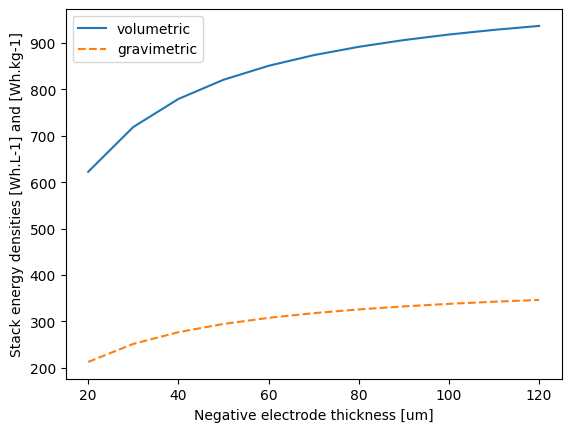

,Parameter,Unit,Value
0,Volumetric energy density,Wh.L-1,936.576473
1,Gravimetric energy density,Wh.kg-1,346.456720
2,Stack average OCP,V,3.714185
3,Capacity,mA.h.cm-2,6.494581
4,(Single-) stack thickness,um,257.555841
5,Stack density,kg.L-1,2.703300


In [3]:
# generate an array of thicknesses from 10e-6 to 100e-6
thicknesses = np.linspace(20e-6, 120e-6, 11)

# initialize lists for the stack energy densities
stack_volumetric_energy_densities = []
stack_gravimetric_energy_densities = []

# if the positive electrode thickness is not set to None, the negative electrode thickness is calculated based on the n/p ratio
# if no n/p is set, the n/p ratio is calculated based on the positive and negative electrode thicknesses
input["Positive electrode thickness [m]"] = None
input["Theoretical n/p ratio"] = 2/3

# loop over the thicknesses and calculate the stack energy densities
for thickness in thicknesses:
    # update the positive electrode thickness in the input
    input.update({"Negative electrode thickness [m]": thickness})
    
    # create a TEA class with the updated input
    tea_class = tea.TEA(base, input)

    # save the calculated stack energy densities in the lists
    stack_volumetric_energy_densities.append(tea_class.stack_energy_densities.get("Volumetric stack energy density [Wh.L-1]"))
    stack_gravimetric_energy_densities.append(tea_class.stack_energy_densities.get("Gravimetric stack energy density [Wh.kg-1]"))
    
# plot stack energy density vs thickness
plt.figure()
plt.plot(thicknesses*1e6, stack_volumetric_energy_densities, label="volumetric")
plt.plot(thicknesses*1e6, stack_gravimetric_energy_densities, label="gravimetric", linestyle='dashed')
plt.xlabel("Negative electrode thickness [um]")
plt.ylabel("Stack energy densities [Wh.L-1] and [Wh.kg-1]")
plt.legend()
plt.show()

# print stack energy densities dataframe for last loop
tea_class.stack_energy_densities_dataframe

Unlike the theoretical n/p ratio, the practical n/p ratio can change with cut-off voltages and initial lithium concentrations. Let's see how the practical n/p ratio and energy densities change with the upper cut-off voltage.

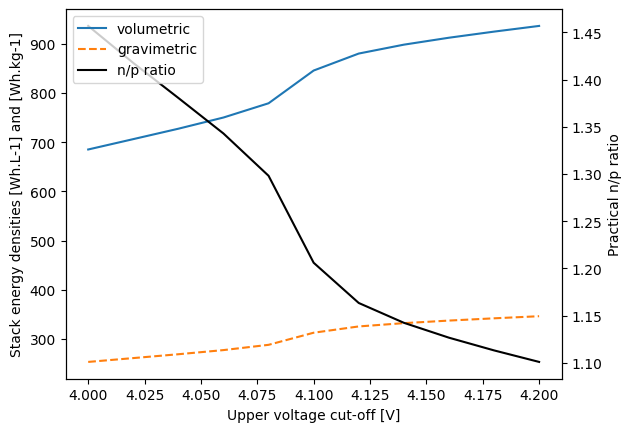

,Parameter,Unit,Value
0,Stack potentials,,
1,Stack average OCP,V,3.714185
2,Maximal OCP,V,4.199987
3,Minimal OCP,V,2.500043
4,Electrode potentials,,
5,Negative electrode average OCP,V,0.193724
6,Positive electrode average OCP,V,3.907909
7,n/p ratio's,,
8,Practical n/p ratio,-,1.101073
9,Theoretical n/p ratio,-,0.666667


In [4]:
# generate an array of thicknesses from 10e-6 to 100e-6
potentials = np.linspace(4, 4.2, 11)

# initialize lists for the stack energy densities
stack_volumetric_energy_densities = []
stack_gravimetric_energy_densities = []
n_p_ratios = []

# loop over the thicknesses and calculate the stack energy densities for the nmc and lfp input-sets
for potential in potentials:
    # update the upper voltage cut-off in the input
    input.update({"Upper voltage cut-off [V]": potential})
    
    # create a TEA classes with the updated input
    tea_class = tea.TEA(base, input)

    # save the calculated the stack energy densities in the lists
    stack_volumetric_energy_densities.append(tea_class.stack_energy_densities.get("Volumetric stack energy density [Wh.L-1]"))
    stack_gravimetric_energy_densities.append(tea_class.stack_energy_densities.get("Gravimetric stack energy density [Wh.kg-1]"))
    n_p_ratios.append(tea_class.stack_energy_densities.get("Practical n/p ratio"))

# plot stack energy density vs thickness and n/p ratio vs thickness on a second axis
fig, ax1 = plt.subplots()
ax1.plot(potentials, stack_volumetric_energy_densities, label="volumetric")
ax1.plot(potentials, stack_gravimetric_energy_densities, label="gravimetric", linestyle='dashed')
ax1.set_xlabel("Upper voltage cut-off [V]")
ax1.set_ylabel("Stack energy densities [Wh.L-1] and [Wh.kg-1]")

ax2 = ax1.twinx()
ax2.plot(potentials, n_p_ratios, color="black", label="n/p ratio")
ax2.set_ylabel("Practical n/p ratio", color="black")
ax2.tick_params(axis='y', labelcolor="black")

# combine the legends for the two axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

# print capacities and potentials dataframe for last loop
tea_class.capacities_and_potentials_dataframe